# ML-Zoomcamp Capstone Project - Bank Marketing

The source data and its description, can be found [here](https://archive.ics.uci.edu/ml/datasets/Pedal+Me+Bicycle+Deliveries).  

[Moro et al., 2014] S. Moro, P. Cortez and P. Rita. A Data-Driven Approach to Predict the Success of Bank Telemarketing. Decision Support Systems, Elsevier, 62:22-31, June 2014

### 1. Importing libraries and loading the data

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('./data/bank-full.csv', sep=';')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


### 2. Data preprocessing

#### 2.1 Duplicates

Taking a look on duplicates:

In [3]:
df[df.duplicated(keep='last')]

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y


Getting rid of duplicate line:

In [4]:
before = df.shape[0]
df.drop_duplicates(inplace=True)
after = df.shape[0]

before, after

(45211, 45211)

#### 2.2 Dealing with column names and value formats

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 6.2+ MB


In [6]:
df.contact.value_counts()

cellular     29285
unknown      13020
telephone     2906
Name: contact, dtype: int64

From the data description, we see a couple of things:

- The features `day` and `month` are not necesary, we already have a variable called `pdays` which stand for the number of days thath passed by after the client was last contacted.

- The variable `contact` is irrelvant (telephone or cellular). We know we're analyzing a telephone marketing campaign. Additionally, `unknown contact` are like 6X the `telephone contact`.

- Column `y` stands for the output variable, which is if the client made a deposit or not, we're going to chainge that. 

Dropping day and month columns:

In [7]:
df.drop(['day', 'month', 'contact'], axis=1, inplace=True)
df.head()

,age,job,marital,education,default,balance,housing,loan,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,198,1,-1,0,unknown,no


In [8]:
df.rename(columns={'y': 'success'}, inplace=True)
df.head()


,age,job,marital,education,default,balance,housing,loan,duration,campaign,pdays,previous,poutcome,success
0,58,management,married,tertiary,no,2143,yes,no,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,198,1,-1,0,unknown,no


We nees to change the yes/no success values into 1/0 values:

In [9]:
df.success = (df.success == 'yes').astype('int')
df.success

0        0
1        0
2        0
3        0
4        0
        ..
45206    1
45207    1
45208    1
45209    0
45210    0
Name: success, Length: 45211, dtype: int64

### 3. Exploratory data analysis and feature importance

Splitting the data (train/val/test = 60%/20%/20%)

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=7)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=7)

len(df) == len(df_train) + len(df_val) + len(df_test)

True

In [12]:
len(df_train), len(df_val), len(df_test)

(27126, 9042, 9043)

In [13]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.success.values
y_val = df_val.success.values
y_test = df_test.success.values

In [14]:
del df_train['success']
del df_val['success']
del df_test['success']

Looking at the target value:

In [15]:
df_full_train.success.value_counts(normalize=True)

0    0.881857
1    0.118143
Name: success, dtype: float64

According to this numbers, about 12% of the clients contacted made a term-deposit into their accounts as a result of the telemarketing campaign.

We can call this the __success rate__.

In [16]:
global_success_rate = df_full_train.success.mean()
round(global_success_rate, 3)

0.118

Looking at numerical and categorical values:

In [17]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27126 entries, 0 to 27125
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        27126 non-null  int64 
 1   job        27126 non-null  object
 2   marital    27126 non-null  object
 3   education  27126 non-null  object
 4   default    27126 non-null  object
 5   balance    27126 non-null  int64 
 6   housing    27126 non-null  object
 7   loan       27126 non-null  object
 8   duration   27126 non-null  int64 
 9   campaign   27126 non-null  int64 
 10  pdays      27126 non-null  int64 
 11  previous   27126 non-null  int64 
 12  poutcome   27126 non-null  object
dtypes: int64(6), object(7)
memory usage: 2.7+ MB


In [18]:
numerical = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']
categorical = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'poutcome']

A closer look at categorical values:

In [19]:
df_full_train[categorical].nunique()

job          12
marital       3
education     4
default       2
housing       2
loan          2
poutcome      4
dtype: int64

Looking at feature importance for categorical values:

In [20]:
from sklearn.metrics import mutual_info_score

In [21]:
def mutual_info_success_score(series):
    return mutual_info_score(series, df_full_train.success)

In [22]:
mutual_info = df_full_train[categorical].apply(mutual_info_success_score)
mutual_info.sort_values(ascending=False)

poutcome     0.029603
housing      0.010089
job          0.008228
education    0.002813
loan         0.002582
marital      0.001976
default      0.000332
dtype: float64

As we see, `[poutcome, housing, job]` have the higher impact when predicting the campaign success, and `[default]` has the significantly lower impact on prediction. 

Looking at feature importance for numerical values:

In [23]:
df_full_train[numerical].corrwith(df_full_train.success).abs().sort_values(ascending=False)

duration    0.390809
pdays       0.101776
previous    0.091025
campaign    0.074874
balance     0.051821
age         0.025072
dtype: float64

There is a significat correlation on the `duration` variable and success. At the same time, it looks like `age` has the least impact on success rate.

### 4. Training models

We are going to be using three different classification models:

- Logistic Regression
- Random Forest Classifier
- XGBoost

In [24]:
from sklearn.feature_extraction import DictVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

from sklearn.metrics import roc_auc_score

Getting the train and val matrices:

In [25]:
train_dict = df_train[numerical + categorical].to_dict(orient='records')
val_dict = df_val[numerical + categorical].to_dict(orient='records')

dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dict)
X_val = dv.transform(val_dict)

Training the Logistic Regression model: using `penalty` parameter for tuning the model.

In [45]:
penalties = ['l1', 'l2']
scores = []

for penalty in penalties:
    log_reg = LogisticRegression(solver='saga', penalty=penalty, max_iter=10000, random_state=7)
    log_reg.fit(X_train, y_train)

    y_pred = log_reg.predict_proba(X_val)[:, 1]
    score = roc_auc_score(y_val, y_pred)
    scores.append((penalty, score))

df_log_reg = pd.DataFrame(scores, columns=['penalty', 'auc'])

In [46]:
df_log_reg

,penalty,auc
0,l1,0.676419
1,l2,0.676421


As we see, there is no a significant difference in using one penalty or the other.

Training a Random Forest model, using `min_samples_leaf` and `max_depth` as tuning parameters:

In [26]:
scores = []

for depth in [10, 15, 20, 25]:
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=n, max_depth=depth, random_state=7)
        rf.fit(X_train, y_train)

        y_pred = rf.predict_proba(X_val)[:, 1]
        score = roc_auc_score(y_val, y_pred)
        scores.append((depth, n, score))

df_rf = pd.DataFrame(scores, columns=['max_depth', 'n_estimators', 'auc'])

In [28]:
df_rf.head()

,max_depth,n_estimators,auc
0,10,10,0.883477
1,10,20,0.888967
2,10,30,0.892106
3,10,40,0.894316
4,10,50,0.894173


Plotting the results:

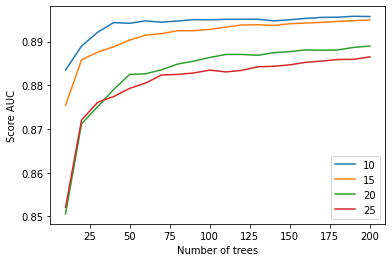

In [30]:
depths = [10, 15, 20, 25]

for depth in depths:
    df_subset = df_rf[df_rf['max_depth'] == depth]
    
    plt.plot(df_subset['n_estimators'], df_subset['auc'], label=depth)

plt.xlabel('Number of trees')
plt.ylabel('Score AUC')
plt.legend()
plt.show()

This chart is telling us that the best performance occurs when `max_depth` is set to 10 levels. Let's repeat but now changeing `min_samples_leaf`:

In [33]:
scores = []

for leaf in [1, 3, 5, 15, 50]:
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=n, max_depth=10, min_samples_leaf=leaf, random_state=7)
        rf.fit(X_train, y_train)

        y_pred = rf.predict_proba(X_val)[:, 1]
        score = roc_auc_score(y_val, y_pred)
        scores.append((leaf, n, score))

df_rf = pd.DataFrame(scores, columns=['min_samples_leaf', 'n_estimators', 'auc'])

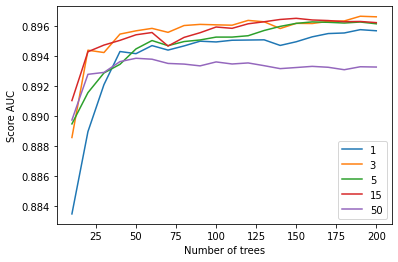

In [34]:
for leaf in [1, 3, 5, 15, 50]:
    df_subset = df_rf[df_rf['min_samples_leaf'] == leaf]
    
    plt.plot(df_subset['n_estimators'], df_subset['auc'], label=leaf)

plt.xlabel('Number of trees')
plt.ylabel('Score AUC')
plt.legend()
plt.show()

It probably needs higher number of trees to se a result, but based on this chart, we can use `min_samples_leaf=3`

In [35]:
scores = []

for leaf in [3, 5, 15]:
    for n in range(10, 401, 30):
        rf = RandomForestClassifier(n_estimators=n, max_depth=10, min_samples_leaf=leaf, random_state=7)
        rf.fit(X_train, y_train)

        y_pred = rf.predict_proba(X_val)[:, 1]
        score = roc_auc_score(y_val, y_pred)
        scores.append((leaf, n, score))

df_rf = pd.DataFrame(scores, columns=['min_samples_leaf', 'n_estimators', 'auc'])

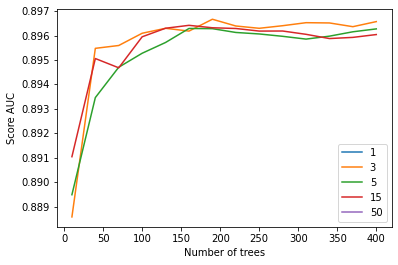

In [36]:
for leaf in [1, 3, 5, 15, 50]:
    df_subset = df_rf[df_rf['min_samples_leaf'] == leaf]
    
    plt.plot(df_subset['n_estimators'], df_subset['auc'], label=leaf)

plt.xlabel('Number of trees')
plt.ylabel('Score AUC')
plt.legend()
plt.show()

Training a XGBoost model, using `eta`as tuning parameter:

In [37]:
feature_names = dv.get_feature_names()

dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=feature_names)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=feature_names)

Setting up the parser:

In [44]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train_auc = float(train_line.split(':')[1])
        val_auc = float(val_line.split(':')[1])

        results.append((it, train_auc, val_auc))

    df_results = pd.DataFrame(results, columns=['num_iteration', 'train_auc', 'val_auc'])
    
    return df_results

In [68]:
scores = {}
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [73]:
%%capture output

eta = 0.1

xgb_params = {
    'eta': eta,
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthreads': 2,

    'seed': 1,
    'verbosity': 0
}

xgboost = xgb.train(xgb_params, dtrain, num_boost_round=200, evals=watchlist)

scores[f'eta={eta}'] = parse_xgb_output(output)

In [74]:
%%capture output

eta = 0.3

xgb_params = {
    'eta': eta,
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthreads': 2,

    'seed': 1,
    'verbosity': 0
}

xgboost = xgb.train(xgb_params, dtrain, num_boost_round=200, evals=watchlist)

scores[f'eta={eta}'] = parse_xgb_output(output)

In [75]:
%%capture output

eta = 0.01

xgb_params = {
    'eta': eta,
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthreads': 2,

    'seed': 1,
    'verbosity': 0
}

xgboost = xgb.train(xgb_params, dtrain, num_boost_round=200, evals=watchlist)

scores[f'eta={eta}'] = parse_xgb_output(output)

Plotting the results:

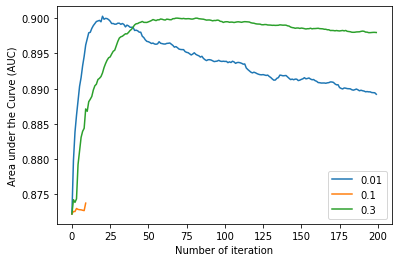

In [76]:
plt.plot(scores['eta=0.01'].num_iteration, scores['eta=0.01'].val_auc, label='0.01')
plt.plot(scores['eta=0.1'].num_iteration, scores['eta=0.1'].val_auc, label='0.1')
plt.plot(scores['eta=0.3'].num_iteration, scores['eta=0.3'].val_auc, label='0.3')
plt.xlabel('Number of iteration')
plt.ylabel('Area under the Curve (AUC)')
plt.legend()

We could select `eta=0.3`

Comparing the three models:

In [79]:
lr = LogisticRegression(max_iter=1000, random_state=7)
lr.fit(X_train, y_train)

y_pred = lr.predict_proba(X_val)[:, 1]
score = roc_auc_score(y_val, y_pred)

score

0.8813725896744764

In [80]:
rf = RandomForestClassifier(n_estimators=50, max_depth=10, min_samples_leaf=3, random_state=7)
rf.fit(X_train, y_train)

y_pred = rf.predict_proba(X_val)[:, 1]
score = roc_auc_score(y_val, y_pred)

score

0.8956966618287373

In [87]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

xgb_params = {
    'eta': 0.3,
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthreads': 2,

    'seed': 1,
    'verbosity': 1
}

xgboost = xgb.train(xgb_params, dtrain, num_boost_round=51, verbose_eval=5, evals=watchlist)

[16:06:17] WARNING: ../src/learner.cc:576: 
Parameters: { "nthreads" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	train-auc:0.87850	val-auc:0.87221
[5]	train-auc:0.90307	val-auc:0.89033
[10]	train-auc:0.91805	val-auc:0.89709
[15]	train-auc:0.92425	val-auc:0.89925
[20]	train-auc:0.92885	val-auc:0.90029
[25]	train-auc:0.93196	val-auc:0.89959
[30]	train-auc:0.93504	val-auc:0.89930
[35]	train-auc:0.93786	val-auc:0.89878
[40]	train-auc:0.93946	val-auc:0.89871
[45]	train-auc:0.94206	val-auc:0.89802
[50]	train-auc:0.94544	val-auc:0.89667


Since Random Forest and XGBoost have similar results, we choose RF because is easer to implement and to monitor.